In [5]:
import pandas as pd
import numpy as np
import re
import pickle

In [6]:
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [7]:
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report

In [69]:
# lab_names = pd.read_csv('/home/jovyan/work/NER-Test/data/labtest_dictionary_v01.csv')
# lab_names = lab_names['test'].tolist()

lab_names = pd.read_csv('data/labtest_dictionary_train_cleaned_v05.csv')
lab_names = lab_names['test name'].tolist()

UNITS = pd.read_csv('data/labtest_units_v02.csv')
UNITS = UNITS['units'].tolist()
UNITS = [str(u).upper() for u in UNITS]
UNITS = list(set(UNITS))

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


def word2features(sent, i):
    word = str(sent[i][0])
    postag = str(sent[i][1])

    isTestName = True if len([token for w in lab_names for token in str(w).upper().split(' ') if token.find(word)>-1])>0 else False
    isUnit = True if word.upper() in UNITS else False
    isDecimal = True if re.findall(r'(\.)', word) and word.isdigit() else False
    isDigit = True if word.isdigit() else False
    isRange = True if re.match(r'\d*.?\d+-\d*.?\d+', word) else False
    #isRange = True if re.match(r'\(\d+-\d+\)', word) else False
    
    features = {
        'word.isTestName()': word if isTestName else '',
        'word.isUnit()': word if isUnit else '',
        'word.isDecimal()': word if isDecimal else '',
        'word.isDigit()': word if isDigit else '',
        'word.isRange()': word if isRange else '',
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    try:
        if i > 0:
            word1 = sent[i - 1][0]
            postag1 = sent[i - 1][1]

            isTestName1 = True if len([token for w in lab_names for token in str(w).upper().split(' ') if token.find(word)>-1])>0 else False
            isUnit1 = True if word.upper() in UNITS else False
            isDecimal1 = True if re.findall(r'(\.)', word1) and word1.isdigit() else False
            isDigit1 = True if word1.isdigit() else False
            isRange1 = True if re.match(r'\d*.?\d+-\d*.?\d+', word1) else False

            features.update({
                '-1word.isTestName()': word1 if isTestName1 else '',
                '-1word.isUnit()': word1 if isUnit1 else '',
                '-1word.isDecimal()': word1 if isDecimal1 else '',
                '-1word.isDigit()': word1 if isDigit1 else '',
                '-1word.isRange()': word1 if isRange1 else '',
                '-1postag': postag1,
                '-1postag[:2]': postag1[:2],
            })
        else:
            #features['BOS'] = True
            features.update({
                'BOS': word
            })

        if i < len(sent) - 1:
            word1 = sent[i + 1][0]
            postag1 = sent[i + 1][1]


            isTestName1 = True if len([token for w in lab_names for token in str(w).upper().split(' ') if token.find(word)>-1])>0 else False
            isUnit1 = True if word.upper() in UNITS else False
            isDecimal1 = True if re.findall(r'(\.)', word1) and word1.isdigit() else False
            isDigit1 = True if word1.isdigit() else False
            isRange1 = True if re.match(r'\d*.?\d+-\d*.?\d+', word1) else False

            features.update({
                '+1word.isTestName()': word1 if isTestName1 else '',
                '+1word.isUnit()': word1 if isUnit1 else '',
                '+1word.isDecimal()': word1 if isDecimal1 else '',
                '+1word.isDigit()': word1 if isDigit1 else '',
                '+1word.isRange()': word1 if isRange1 else '',
                '+1postag': postag1,
                '+1postag[:2]': postag1[:2],
            })
        else:
            #features['EOS'] = True        
            features.update({
                'EOS': word
            })
    except:
        print(sent,word)

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    return [label for token, postag, label in sent]


def sent2tokens(sent):
    return [token for token, postag, label in sent]


def extract_labs(t):
    if len(t)<1:
        return ['','']

    t = re.sub(r'\"','',str(t).strip())    
    t = re.sub(r'[^A-Z0-9-\.]',' ',str(t).strip().upper())            
    t = re.sub(r'([\s]*)(-)([\s]*)',r'\1 \3',str(t).strip().upper())

    wordlist = nltk.pos_tag(nltk.word_tokenize(str(t)))
    tagged_list = []
    for atagged in wordlist:
        tagged_list.append([0,atagged[0],atagged[1]])
    tagged_df = pd.DataFrame(tagged_list)
    if tagged_df.shape[0]==0:
        return ['','']
    tagged_df = tagged_df.rename(columns={0:'Sentence #',1:'Word',2:'POS'})
    
    #print(tagged_df.head())
    func = lambda s: [(w, p) for w, p in zip(s["Word"].values.tolist(), s["POS"].values.tolist())]
    grouped = tagged_df.groupby("Sentence #").apply(func)
    sentences = [s for s in grouped]
    test_sents = sentences
    
    X_test = [sent2features(s) for s in test_sents]
    y_pred = crf_model.predict(X_test)
    prediction = []
    for sent, label in zip(test_sents,y_pred):
        asent = []
        atruth = []
        apred = []
        for s, l in zip(sent, label):
            asent.append(s[0])

            if l == 'LAB':
                apred.append(s[0])
        prediction.append([' '.join(asent), ' '.join(apred)])
    sent, lab = prediction[0]    
    return [sent, lab]



In [70]:
def make_tagged_set(df_sent):

    df_sent = df_sent.fillna(value='')

    filtered = []
    for key, values in df_sent.iterrows():
        arow = []
        for v in values:            
            v = re.sub(r'\"','',str(v).strip())            
            v = re.sub(r'[^A-Z0-9-\.]',' ',str(v).strip().upper())            
            v = re.sub(r'([\s]*)(-)([\s]*)',r'\1 \3',str(v).strip().upper())
            arow.append(v)

        tags = []
        term = ' '.join(arow[:-1])
        wordlist = nltk.pos_tag(nltk.word_tokenize(term))        
            
        for i in range(len(wordlist)):
            aword, apos = wordlist[i]
            atag = arow[-1] if arow[-1]!='' else 'O'
            tags.append((aword, apos, atag))
        filtered.append(pd.DataFrame(tags))

    tagged_list = []
    for key, values in enumerate(filtered):
        for k,atagged in values.iterrows():
            tagged_list.append([key, atagged[0], atagged[1], atagged[2]])
    tagged_df = pd.DataFrame(tagged_list)
    tagged_df = tagged_df.rename(columns={0: 'Sentence #', 1: 'Word', 2: 'POS', 3: 'Tag'})
    tagged_df.shape
    
    return tagged_df

In [10]:
df_train_data = pd.read_csv('data/train/train_round123_validated_v31.csv')
df_train_data_freq = pd.read_csv('data/train/train_round123_validated_freq_v31.csv')
df_train_data = df_train_data.fillna(value='')
df_train_data_freq = df_train_data_freq[df_train_data_freq['freq']>2][['lab_result_0','CLASS']].copy()
df_train_data = pd.concat([df_train_data[df_train_data['CLASS']==''].sample(frac=0.1, random_state=42),df_train_data_freq])
df_train_data['lab_result_0'] = df_train_data['lab_result_0'].apply(lambda s: re.sub(r'\d{1,2}\/\d{1,2}\/\d{2,4}[\s]+\d{1,2}[:\d{1,2}]+|\d{1,2}\/\d{1,2}\/\d{2,4}|\d{1,2}[:\d{1,2}]+','',str(s)).strip())
df_train_data = df_train_data.fillna(value='')
df_train_data['select'] = df_train_data['lab_result_0'].apply(lambda s: False if len(str(s).strip())<1 else True)
df_train_data = df_train_data[df_train_data['select']][['lab_result_0','CLASS']].copy()
df_train_data.shape

(40614, 2)

In [11]:
train = df_train_data.copy()
train = train.dropna(subset=['lab_result_0'])

train_tagged = make_tagged_set(train)
# train_tagged = train_tagged.fillna(method="ffill")
# words = list(set(train_tagged["Word"].values))
# n_words = len(words)
# tags = list(set(train_tagged["Tag"].values))
# n_tags = len(tags)
# getter = SentenceGetter(train_tagged)
# train_sentences = getter.sentences

# train_sents = train_sentences

In [12]:
data = train_tagged.fillna(method="ffill") #data.fillna(method="ffill")
words = list(set(data["Word"].values))
n_words = len(words); n_words
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags
# class SentenceGetter(object):
    
#     def __init__(self, data):
#         self.n_sent = 1
#         self.data = data
#         self.empty = False
#         agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
#                                                            s["POS"].values.tolist(),
#                                                            s["Tag"].values.tolist())]
#         self.grouped = self.data.groupby("Sentence #").apply(agg_func)
#         self.sentences = [s for s in self.grouped]
    
#     def get_next(self):
#         try:
#             s = self.grouped["Sentence: {}".format(self.n_sent)]
#             self.n_sent += 1
#             return s
#         except:
#             return None
getter = SentenceGetter(data)
sentences = getter.sentences
max_len = 75
max_len_char = 10
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


In [13]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)


In [14]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])


In [15]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 10)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 75)]         0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 75, 10, 10)  390         ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 embedding (Embedding)          (None, 75, 20)       150860      ['input_1[0][0]']            

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=3)
history = model.fit([X_word_tr, np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=100, callbacks=[callback], validation_split=0.1, verbose=1)


Epoch 1/100
1026/1026 [==============================] - 656s 634ms/step - loss: 0.0106 - acc: 0.9171 - val_loss: 0.0033 - val_acc: 0.9837
Epoch 2/100
1026/1026 [==============================] - 656s 639ms/step - loss: 0.0020 - acc: 0.9911 - val_loss: 0.0026 - val_acc: 0.9891
Epoch 3/100
1026/1026 [==============================] - 660s 644ms/step - loss: 0.0013 - acc: 0.9938 - val_loss: 0.0023 - val_acc: 0.9902
Epoch 4/100
1026/1026 [==============================] - 658s 642ms/step - loss: 9.6458e-04 - acc: 0.9960 - val_loss: 0.0024 - val_acc: 0.9892
Epoch 5/100
1026/1026 [==============================] - 662s 645ms/step - loss: 9.1208e-04 - acc: 0.9960 - val_loss: 0.0025 - val_acc: 0.9892
Epoch 6/100
1026/1026 [==============================] - 652s 636ms/step - loss: 9.4894e-04 - acc: 0.9957 - val_loss: 0.0024 - val_acc: 0.9892
Epoch 7/100
1026/1026 [==============================] - 660s 643ms/step - loss: 7.8168e-04 - acc: 0.9967 - val_loss: 0.0023 - val_acc: 0.9914
Epoch 8/100

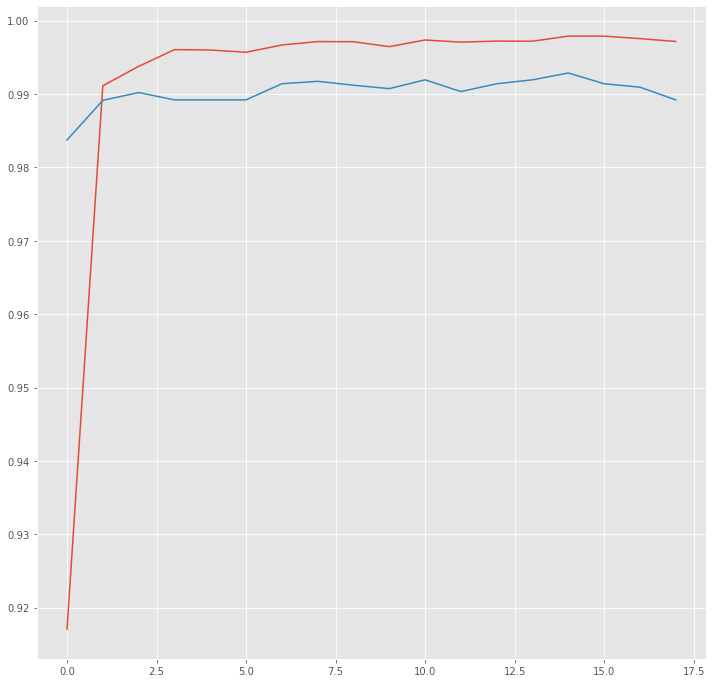

In [17]:
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [18]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
for i in range(y_pred.shape[0]):
    p = np.argmax(y_pred[i], axis=-1)
    print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    print(30 * "=")
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
RBC            : LAB   LAB
MORPH          : LAB   LAB
COMMENT        : LAB   LAB
NORMAL         : LAB   LAB
Word           ||True ||Pred
ANION          : LAB   LAB
GAP            : LAB   LAB
Word           ||True ||Pred
TOTAL          : LAB   LAB
BILIRUBIN      : LAB   LAB
0.8            : LAB   LAB
Word           ||True ||Pred
URINALYSIS     : LAB   LAB
NORMAL         : LAB   LAB
Word           ||True ||Pred
RHYTHM         : O     O
REGULAR        : O     O
RHYTHM         : O     O
Word           ||True ||Pred
NEUT           : LAB   LAB
AUTO           : LAB   LAB
NOT            : LAB   LAB
REPORTABLE     : LAB   LAB
Word           ||True ||Pred
BASO           : LAB   LAB
AUTO           : LAB   LAB
0.0            : LAB   LAB
Word           ||True ||Pred
URINE          : LAB   LAB
UROBILINOGEN   : LAB   LAB
Word           ||True ||Pred
URINE          : LAB   LAB
COLOR          : LAB   LAB
YELLOW         : LAB   LAB
Word           ||True ||Pred
LYMPHOCYTES   

.5             : LAB   LAB
.5             : LAB   LAB
Word           ||True ||Pred
NEW            : O     O
ONDANSETRON    : O     O
4              : O     O
MG             : O     O
TABLET         : O     O
DISINTEGRATING : O     O
Word           ||True ||Pred
FUROSEMIDE     : O     O
FUROSEMIDE     : O     O
MG             : O     O
ORAL           : O     O
TABLET         : O     O
TAKE           : O     O
2              : O     O
AND            : O     O
1              : O     O
2              : O     O
TABS           : O     O
DAILY          : O     O
MG             : O     O
.              : O     O
REFILLS        : O     O
3              : O     O
.              : O     O
Word           ||True ||Pred
RDW            : LAB   LAB
.0             : LAB   LAB
.0             : LAB   LAB
Word           ||True ||Pred
NEUROLOGIC     : O     O
ORIENTED       : O     O
X              : O     O
NO             : O     O
SENSORY        : O     O
DEFICITS       : O     O
AND            : O     O

BILATERALLY    : O     O
Word           ||True ||Pred
ROUTE          : O     O
Word           ||True ||Pred
URINE          : LAB   LAB
GLUCOSE        : LAB   LAB
UA             : LAB   LAB
Word           ||True ||Pred
ALBUMIN        : LAB   LAB
ALBUMIN        : LAB   LAB
2.5            : LAB   LAB
L              : LAB   LAB
3.3            : LAB   LAB
5.0            : LAB   LAB
Word           ||True ||Pred
ALT            : LAB   LAB
Word           ||True ||Pred
U              : LAB   LAB
BENZODIAZEPINES: LAB   LAB
SCRN           : LAB   LAB
Word           ||True ||Pred
NITRITE        : LAB   LAB
POSITIVE       : LAB   LAB
A              : LAB   LAB
NORMAL         : LAB   LAB
NEGAT          : LAB   LAB
Word           ||True ||Pred
CREATININE     : LAB   LAB
1              : LAB   LAB
.              : LAB   LAB
H              : LAB   LAB
0              : LAB   LAB
.              : LAB   LAB
1              : LAB   LAB
.              : LAB   LAB
MG             : LAB   LAB
DL             : L

Word           ||True ||Pred
URINE          : LAB   LAB
COLOR          : LAB   LAB
AUTO           : LAB   LAB
Word           ||True ||Pred
POTASSIUM      : LAB   LAB
LEVEL          : LAB   LAB
4.4            : LAB   LAB
MMOL           : LAB   LAB
L              : LAB   LAB
Word           ||True ||Pred
URINE          : LAB   LAB
OPIATES        : LAB   LAB
SCREEN         : LAB   LAB
Word           ||True ||Pred
SODIUM         : LAB   LAB
Word           ||True ||Pred
LEVALBUTEROL   : O     O
HCL            : O     O
1              : O     O
.              : O     O
MG             : O     O
3              : O     O
ML             : O     O
1              : O     O
.              : O     O
MG             : O     O
INHALATION     : O     O
Q4H            : O     O
PRN            : O     O
ML             : O     O
Word           ||True ||Pred
RBC            : LAB   LAB
5              : LAB   LAB
.              : LAB   LAB
Word           ||True ||Pred
ALKALINE       : LAB   LAB
PHOSPHATASE    

URINE          : LAB   LAB
COCAINE        : LAB   LAB
SCREEN         : LAB   LAB
Word           ||True ||Pred
VACCINATOR     : O     O
VICTORIA       : O     O
HURST          : O     O
Word           ||True ||Pred
NEUT           : LAB   LAB
AUTO           : LAB   LAB
NOT            : LAB   LAB
REPORTABLE     : LAB   LAB
Word           ||True ||Pred
SODIUM         : LAB   LAB
Word           ||True ||Pred
DO             : O     O
YOU            : O     O
OR             : O     O
HAVE           : O     O
YOU            : O     O
EVER           : O     O
USED           : O     O
SMOKELESS      : O     O
TOBACCO        : O     O
NEVER          : O     O
USED           : O     O
SMOKELESS      : O     O
TOBACCO        : O     O
Word           ||True ||Pred
COMPREH        : LAB   LAB
METAB          : LAB   LAB
PANEL          : LAB   LAB
Word           ||True ||Pred
NEUT           : LAB   LAB
AUTO           : LAB   LAB
Word           ||True ||Pred
NEUT           : LAB   LAB
AUTO           : LA

SUCH           : O     O
AS             : O     O
Word           ||True ||Pred
MEDICATION     : O     O
TO             : O     O
PICK           : O     O
UP             : O     O
PATIENT        : O     O
WILL           : O     O
SEE            : O     O
DR.            : O     O
RATHBUN        : O     O
IN             : O     O
THE            : O     O
SALINA         : O     O
CLINIC         : O     O
ON             : O     O
MONDAY         : O     O
AT             : O     O
3              : O     O
PM             : O     O
FOR            : O     O
FOLLOW         : O     O
UP             : O     O
.              : O     O
Word           ||True ||Pred
POTASSIUM      : LAB   LAB
3.5            : LAB   LAB
L              : LAB   LAB
Word           ||True ||Pred
AST            : LAB   LAB
U              : LAB   LAB
L              : LAB   LAB
H              : LAB   LAB
Word           ||True ||Pred
SODIUM         : LAB   LAB
L              : LAB   LAB
MMOL           : LAB   LAB
L             

PCR            : LAB   LAB
GENEXPERT      : LAB   LAB
NEGATIVE       : LAB   LAB
Word           ||True ||Pred
CARBON         : LAB   LAB
DIOXIDE        : LAB   LAB
.0             : LAB   LAB
L              : LAB   LAB
MMOL           : LAB   LAB
L              : LAB   LAB
Word           ||True ||Pred
PLT            : LAB   LAB
WEEKS          : LAB   LAB
Word           ||True ||Pred
SERVICE        : O     O
DEPT           : O     O
.              : O     O
SALINA         : O     O
FAMILY         : O     O
HEALTHCARE     : O     O
CENTER         : O     O
Word           ||True ||Pred
VACCINE        : O     O
TYPE           : O     O
MMR            : O     O
Word           ||True ||Pred
ALTERED        : O     O
MENTATION      : O     O
GLASCOW        : O     O
COMA           : O     O
SCALE          : O     O
SCORE          : O     O
NO             : O     O
Word           ||True ||Pred
IMPRESSION     : O     O
1              : O     O
.              : O     O
NO             : O     O
ACUT

URINE          : LAB   LAB
GLUCOSE        : LAB   LAB
UA             : LAB   LAB
Word           ||True ||Pred
FM             : O     O
Word           ||True ||Pred
NEUT           : LAB   LAB
AUTO           : LAB   LAB
Word           ||True ||Pred
EOS            : LAB   LAB
ABS            : LAB   LAB
0.0            : LAB   LAB
0.3            : LAB   LAB
Word           ||True ||Pred
D              : LAB   LAB
DIMER          : LAB   LAB
Word           ||True ||Pred
HGB            : LAB   LAB
WEEKS          : LAB   LAB
9.9            : LAB   LAB
GM             : LAB   LAB
DL             : LAB   LAB
.0             : LAB   LAB
.0             : LAB   LAB
Word           ||True ||Pred
HOW            : O     O
MANY           : O     O
YEARS          : O     O
HAVE           : O     O
YOU            : O     O
SMOKED         : O     O
TOBACCO        : O     O
0              : O     O
Word           ||True ||Pred
ALK            : LAB   LAB
PHOS           : LAB   LAB
IU             : LAB   LAB
L    

In [19]:
y_pre = np.argmax(y_pred,axis=-1)

In [20]:
tag_true = []
tag_pred = []

for i in range(y_pred.shape[0]):
    p = np.argmax(y_pred[i], axis=-1)
    #print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    #print(30 * "=")
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            tag_true.append(idx2tag[t])
            tag_pred.append(idx2tag[pred])
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

sorted_labels = ['O','LAB']
print(classification_report(tag_true, tag_pred,digits=3, target_names=sorted_labels))

              precision    recall  f1-score   support

           O      0.987     0.995     0.991     11137
         LAB      0.992     0.979     0.985      6865

    accuracy                          0.989     18002
   macro avg      0.989     0.987     0.988     18002
weighted avg      0.989     0.989     0.989     18002



In [21]:
pickle.dump(model, open('models/lstm_model_lab_round123_v031.pkl','wb'))

INFO:tensorflow:Assets written to: ram://91d9c2f8-e300-4f71-9946-344b1c7b31e5/assets


In [31]:
model.save('models/bi_lstm_model_lab_round123_v031')

INFO:tensorflow:Assets written to: models/bi_lstm_model_lab_round123_v031\assets


INFO:tensorflow:Assets written to: models/bi_lstm_model_lab_round123_v031\assets


In [32]:

from tensorflow import keras
from keras_bert import get_custom_objects

In [33]:
custom_objects = get_custom_objects()
model = keras.models.load_model('models/bi_lstm_model_lab_round123_v031',custom_objects)


# TEST

In [92]:
df_test_data = pd.read_csv('data/train/train_round123_validated_v31.csv')
#df_train_data_freq = pd.read_csv('data/train/train_round123_validated_freq_v31.csv')
df_test_data = df_test_data.fillna(value='')
#df_train_data_freq = df_train_data_freq[df_train_data_freq['freq']>2][['lab_result_0','CLASS']].copy()
#df_train_data = pd.concat([df_train_data[df_train_data['CLASS']==''].sample(frac=0.1, random_state=42),df_train_data_freq])
df_test_data['lab_result_0'] = df_test_data['lab_result_0'].apply(lambda s: re.sub(r'\d{1,2}\/\d{1,2}\/\d{2,4}[\s]+\d{1,2}[:\d{1,2}]+|\d{1,2}\/\d{1,2}\/\d{2,4}|\d{1,2}[:\d{1,2}]+','',str(s)).strip())
df_test_data = df_test_data.fillna(value='')
#df_train_data['select'] = df_train_data['lab_result_0'].apply(lambda s: False if len(str(s).strip())<1 else True)
#df_train_data = df_train_data[df_train_data['select']][['lab_result_0','CLASS']].copy()
df_test_data.shape

(119068, 2)

In [93]:
test = df_test_data.copy()
test = test.dropna(subset=['lab_result_0'])

test_tagged = make_tagged_set(test)

In [94]:
data = test_tagged.fillna(method="ffill") #data.fillna(method="ffill")
words = list(set(data["Word"].values))
n_words = len(words); n_words
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

getter = SentenceGetter(data)
sentences = getter.sentences

y_true = df_test_data['CLASS'].tolist()

In [95]:
X_word = []
for s in sentences:
    wordlist =[]
    for w in s:
        if w[0] in word2idx:
            wordlist.append(word2idx[w[0]])
        else:
            wordlist.append(word2idx['PAD'])
    X_word.append(wordlist)
    


In [96]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx['PAD'], padding='post', truncating='post')
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)


In [97]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if char2idx.get(sentence[i][0][j]):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get('PAD'))
            except:
                word_seq.append(char2idx.get('PAD'))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq, dtype=np.int32))

    
test_word = X_word
test_char = X_char

In [98]:
len(test_word),len(test_char),np.array(test_char).shape

(116456, 116456, (116456, 75, 10))

In [99]:
np_char = np.array(test_char)
np_char.shape

(116456, 75, 10)

In [100]:
#model = pickle.load(open('models/lstm_model_lab_round123_v031.pkl','rb'))


In [101]:
y_pred = model.predict([test_word, np.array(test_char).reshape((len(test_char), max_len, max_len_char))])

In [106]:
prediction = []
    
for i in range(y_pred.shape[0]):
    p = np.argmax(y_pred[i], axis=-1)
    asent = []
    aunit = []
    #print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    #print(30 * "=")
    for w, pred in zip(X_word[i], p):    
        if w != 0:
            asent.append(idx2word[w])
            if idx2tag[pred] == 'LAB':
                aunit.append(idx2tag[pred])
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[pred]))
    prediction.append([' '.join(asent),' '.join(list(set(aunit))), len(asent)==len(aunit),len(asent), len(aunit)])
            
            
pred_df = pd.DataFrame(prediction)
pred_df = pred_df.rename(columns={0:'test',1:'LAB',2:'check',3:'send_len',4:'unit_len'})
pred_df.to_csv('data/test/train_round123_validated_v32.csv')
pred_df.head()

,test,LAB,check,send_len,unit_len
0,COUNTY HEALTH CENTER DRIVE KS,,False,5,0
1,EMERGENCY DEPARTMENT REPORT,,False,3,0
2,PATIENT TERESA M MR MR,,False,5,0
3,DOB AGE ACCT CV,,False,4,0
4,SEX F REPORT,,False,3,0
